In [1]:
import torch
from torch import nn

import sys
sys.path.append("..")
import pandas as pd

from low_precision_utils import utils
from low_precision_utils import metrics
import numpy as np
import copy
import torch.optim
from torch import nn
import qtorch.quant
import qtorch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
from IPython.display import HTML




In [2]:

def loadLinearData(device):
    from sklearn.model_selection import train_test_split
    from sklearn.datasets import fetch_openml

    # Load the Boston Housing Dataset
    boston = fetch_openml(name='boston', version=1)

    # Creating a DataFrame
    boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)

    # Adding the target variable to the DataFrame
    boston_df['PRICE'] = boston.target

    # Display the first few rows of the dataset
    print(boston_df.head())

    # Selecting multiple features
    features = ['CRIM', 'RM', 'AGE', 'DIS', 'LSTAT']
    X = boston_df[features].values
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    y = boston_df['PRICE'].values
    y = (y - y.mean()) / y.std() 

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return (torch.tensor(X_train, dtype=torch.float32).to(device), 
            torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device), 
            torch.tensor(X_test, dtype=torch.float32).to(device), 
            torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device))

X_train, y_train, X_test, y_test = loadLinearData('cpu')

      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  PRICE  
0  396.90   4.98   24.0  
1  396.90   9.14   21.6  
2  392.83   4.03   34.7  
3  394.63   2.94   33.4  
4  396.90   5.33   36.2  


In [128]:
DATASIZE = 10
LR = 0.01
BATCH_SIZE = 404

def problem(BATCH_SIZE, bits=0):
    w = torch.randn(5, 1, requires_grad=False)
    b = torch.tensor(0.0, requires_grad=False)

    # ref_w = torch.tensor([[3.0], [2.0]], requires_grad=False)
    # x = torch.randn(DATASIZE, 2, requires_grad=False)
    # y = x @ ref_w + 2 + torch.randn(DATASIZE, 1) * 0.01
    x = X_train
    y = y_train
    # optimal mse loss -> 0.01
    start = -100
    end = -1

    logger = metrics.Logger()
    number = qtorch.FloatingPoint(8, bits)
    quantizer = qtorch.quant.Quantizer(number)

    def getBatch(batch_size):
        replace=False
        if batch_size >= DATASIZE:
            replace=True
        indices = np.random.choice(DATASIZE, batch_size, replace=replace)
        return x[indices], y[indices]

    def add_noise(x):
        # noise = (torch.rand(*x_batch.shape) - 0.5)
        # noise[noise > 0] = 0.5
        # noise[noise <= 0] = -0.5
        # return x + noise
        return quantizer(x)
        
    def theoratical_grad(w, b, x, y):
        y_hat = x @ w + b
        d_y_hat = 2 * (y_hat - y) / BATCH_SIZE
        d_w = x.t() @ d_y_hat
        d_b = d_y_hat.sum()
        return d_w, d_b

    with torch.autograd.no_grad():
        for i in range(10000):
            x_batch, y_batch = getBatch(BATCH_SIZE)
            x_q = add_noise(x_batch)

            # forward
            y_hat = x_q @ w + b
            loss = torch.mean((y_hat - y_batch)**2)

            # backward
            d_y_hat = 2 * (y_hat - y_batch) / BATCH_SIZE
            x_q = add_noise(x_batch)
            d_w = x_q.t() @ d_y_hat
            d_b = d_y_hat.sum()

            # update
            w -= LR * d_w
            b -= LR * d_b

            real_d_w, real_d_b = theoratical_grad(w, b, x_batch, y_batch)
            theoratical_grad_norm = torch.sqrt((real_d_w**2).sum() + real_d_b**2)
            result = { "loss": loss.item(), 
                    "grad_norm": torch.sqrt((d_w**2).sum() + d_b**2).item(),
                    "real_grad_norm": theoratical_grad_norm.item() }
            for i, v in enumerate(w):
                result[f'w{i}'] = v.item()
                result[f"w{i}_grad"] = d_w[i].item()
                result[f"w{i}_real_grad"] = real_d_w[i].item()
            result['b'] = b.item()
            result['b_grad'] = d_b.item()
            result['b_real_grad'] = real_d_b.item()
            logger.log(result)
    return logger


logger = problem(BATCH_SIZE, 0)


-0.000851572768879123
0.0401362527779182
0.0008920033236790914
0.024905230308463665
0.09573822336271405
0.04988072011154145


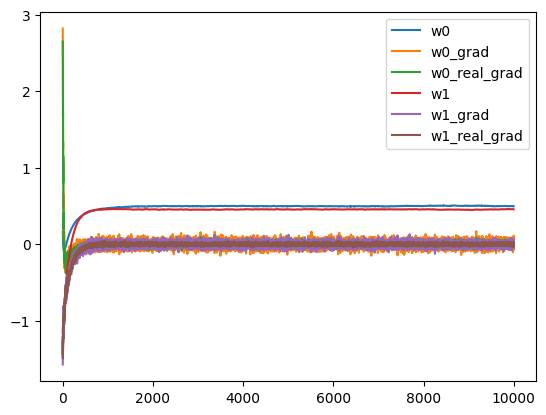

In [129]:
start=0
end=-1
plt.plot(logger.metrics["w0"][start:end], label="w0")
plt.plot(logger.metrics["w0_grad"][start:end], label="w0_grad")
plt.plot(logger.metrics["w0_real_grad"][start:end], label="w0_real_grad")
plt.plot(logger.metrics["w1"][start:end], label="w1")
plt.plot(logger.metrics["w1_grad"][start:end], label="w1_grad")
plt.plot(logger.metrics["w1_real_grad"][start:end], label="w1_real_grad")
# plt.plot(logger.metrics["b"][start:end], label="b")
# plt.plot(logger.metrics["b_grad"][start:end], label="b_grad")
# plt.plot(logger.metrics["b_real_grad"][start:end], label="b_real_grad")
plt.legend()

print(np.average(logger.metrics["w0_grad"][-100:]))
print(np.std(logger.metrics["w0_grad"][-100:]))
print(np.average(logger.metrics["w0_real_grad"][-100:]))
print(np.std(logger.metrics["w0_real_grad"][-100:]))

print(np.average(logger.metrics["grad_norm"][-100:]))
print(np.average(logger.metrics["real_grad_norm"][-100:]))

In [119]:
for i in range(5):
    print(logger.metrics[f"w{i}"][-1])

-0.14075222611427307
0.4138193130493164
-0.08240452408790588
-0.18347309529781342
-0.46619802713394165


In [108]:
real_ws = [ -0.14355529844760895, 0.4154549837112427, -0.08582913130521774, -0.1984323412179947, -0.48164287209510803 ]

In [109]:

loggers = []
for m in [0, 1, 23]:
    tlogger = metrics.Logger()
    for b in [10, 20, 40, 80, 160, 320, 404]:
        logger = problem(b, m)
        tlogger.log({
            "batch_size": b,
            "w0_grad": np.average(logger.metrics["w0_grad"][-100:]),
            "w0_real_grad": np.average(logger.metrics["w0_real_grad"][-100:]),
            "grad_norm": np.average(logger.metrics["grad_norm"][-100:]),
            "real_grad_norm": np.average(logger.metrics["real_grad_norm"][-100:]),
            "w0_grad_std": np.std(logger.metrics["w0_grad"][-100:]),
            "w0_real_grad_std": np.std(logger.metrics["w0_real_grad"][-100:]),
            "grad_norm_std": np.std(logger.metrics["grad_norm"][-100:]),
            "real_grad_norm_std": np.std(logger.metrics["real_grad_norm"][-100:])
        })
        print(b)
    loggers.append(tlogger)

10
20
40
80
160
320
404
10
20
40
80
160
320
404
10
20
40
80
160
320
404


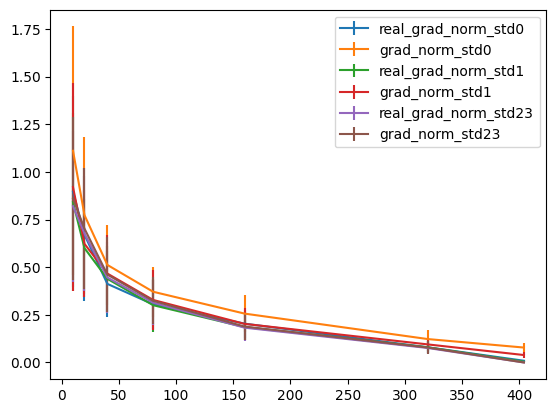

In [114]:
# plt.plot(tlogger.metrics["batch_size"], tlogger.metrics["w0_grad"], label="w0_grad")
# plt.plot(tlogger.metrics["batch_size"], tlogger.metrics["w0_real_grad"], label="w0_real_grad")
# std bars
    # plt.errorbar(tlogger.metrics["batch_size"], tlogger.metrics["w0_grad"], yerr=bar1, label="w0_grad_std")
    # plt.errorbar(tlogger.metrics["batch_size"], tlogger.metrics["w0_real_grad"], yerr=bar2, label="w0_real_grad_std")

    # plt.plot(tlogger.metrics["batch_size"], tlogger.metrics["grad_norm"], label="grad_norm")
    
    # plt.plot(tlogger.metrics["batch_size"], tlogger.metrics["real_grad_norm"], label="real_grad_norm")

    # plt.errorbar(tlogger.metrics["batch_size"], tlogger.metrics["grad_norm"], yerr=np.array(tlogger.metrics["grad_norm_std"]), label=f"{i}grad_norm_std")
man0_logger = loggers[0]
plt.errorbar(man0_logger.metrics["batch_size"], man0_logger.metrics["real_grad_norm"], yerr=np.array(man0_logger.metrics["real_grad_norm_std"]), label=f"real_grad_norm_std0")
plt.errorbar(man0_logger.metrics["batch_size"], man0_logger.metrics["grad_norm"], yerr=np.array(man0_logger.metrics["grad_norm_std"]), label=f"grad_norm_std0")

man1_logger = loggers[1]
plt.errorbar(man1_logger.metrics["batch_size"], man1_logger.metrics["real_grad_norm"], yerr=np.array(man1_logger.metrics["real_grad_norm_std"]), label=f"real_grad_norm_std1")
plt.errorbar(man1_logger.metrics["batch_size"], man1_logger.metrics["grad_norm"], yerr=np.array(man1_logger.metrics["grad_norm_std"]), label=f"grad_norm_std1")

man23_logger = loggers[2]
plt.errorbar(man23_logger.metrics["batch_size"], man23_logger.metrics["real_grad_norm"], yerr=np.array(man23_logger.metrics["real_grad_norm_std"]), label=f"real_grad_norm_std23")
plt.errorbar(man23_logger.metrics["batch_size"], man23_logger.metrics["grad_norm"], yerr=np.array(man23_logger.metrics["grad_norm_std"]), label=f"grad_norm_std23")

plt.legend()

In [117]:
man1_logger.metrics["real_grad_norm"][-1]

0.004131045277463272

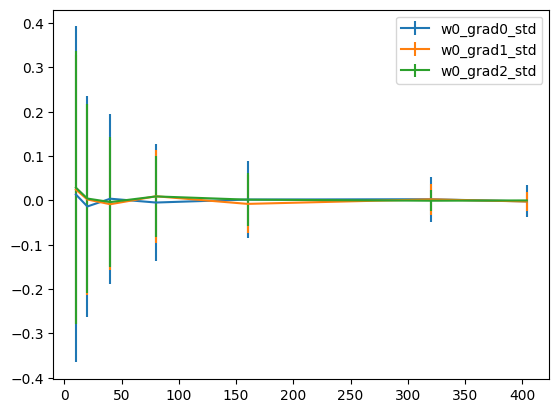

In [115]:
for i, tlogger in enumerate(loggers):
    # plt.plot(tlogger.metrics["batch_size"], tlogger.metrics[f"w0_grad"], label=f"w0_grad{i}")
    plt.errorbar(tlogger.metrics["batch_size"], tlogger.metrics[f"w0_grad"], yerr=np.array(tlogger.metrics[f"w0_grad_std"]), label=f"w0_grad{i}_std")

plt.legend()

In [112]:
print(tlogger.metrics["real_grad_norm"])
print(tlogger.metrics["real_grad_norm_std"])

[0.8201669310033322, 0.6768712437152863, 0.44588705338537693, 0.31404111385345457, 0.18259116526693106, 0.07600367471575736, 2.1765404767393193e-06]
[0.3953399151118189, 0.2999923739908274, 0.18849343907761, 0.1191711763877243, 0.0686175701324004, 0.03159023368057505, 1.642577244895102e-08]


In [113]:
plt.plot([abs(i/100) for i in grads], label='Grad')


NameError: name 'grads' is not defined

In [104]:
np.average(grads[-100:])

9.567990684851894

In [160]:
DATASIZE = 10
LR = 0.03
BATCH_SIZE = 404

device = "cuda:2"
def problem(BATCH_SIZE, bits=0):
    w = torch.randn(5, 1, requires_grad=False, device=device)
    b = torch.tensor(0.0, requires_grad=False, device=device)

    x = X_train.to(device)
    y = y_train.to(device)

    logger = metrics.Logger()
    number = qtorch.FloatingPoint(8, bits)
    quantizer = qtorch.quant.Quantizer(number)

    def getBatch(batch_size):
        replace=False
        if batch_size >= DATASIZE:
            replace=True
        indices = np.random.choice(DATASIZE, batch_size, replace=replace)
        return x[indices], y[indices]

    def add_noise(x):
        # noise = (torch.rand(*x_batch.shape) - 0.5)
        # noise[noise > 0] = 0.5
        # noise[noise <= 0] = -0.5
        # return x + noise
        return quantizer(x)
        
    def theoratical_grad(w, b, x, y):
        y_hat = x @ w + b
        d_y_hat = 2 * (y_hat - y) / BATCH_SIZE
        d_w = x.t() @ d_y_hat
        d_b = d_y_hat.sum()
        return d_w, d_b

    with torch.autograd.no_grad():
        for i in range(10000):
            x_batch, y_batch = getBatch(BATCH_SIZE)
            x_q = add_noise(x_batch)

            # forward
            y_hat = x_q @ w + b
            loss = torch.mean((y_hat - y_batch)**2)

            # backward
            d_y_hat = 2 * (y_hat - y_batch) / BATCH_SIZE
            x_q = add_noise(x_batch)
            d_y_hat = add_noise(d_y_hat)

            d_w = x_q.t() @ d_y_hat
            d_b = d_y_hat.sum()

            # update
            w -= LR * d_w
            b -= LR * d_b

            if i % 10 == 0:
                real_d_w, real_d_b = theoratical_grad(w, b, x_batch, y_batch)
                theoratical_grad_norm = torch.sqrt((real_d_w**2).sum() + real_d_b**2)
                result = { "loss": loss.item(), 
                        "grad_norm": torch.sqrt((d_w**2).sum() + d_b**2).item(),
                        "real_grad_norm": theoratical_grad_norm.item() }
                for i, v in enumerate(w):
                    result[f'w{i}'] = v.item()
                    result[f"w{i}_grad"] = d_w[i].item()
                    result[f"w{i}_real_grad"] = real_d_w[i].item()
                result['b'] = b.item()
                result['b_grad'] = d_b.item()
                result['b_real_grad'] = real_d_b.item()
                logger.log(result)
    return logger


logger = problem(BATCH_SIZE, 0)


In [161]:
r = {}
for m in [0, 1, 23]:
    for b in [8, 16, 32, 64, 128, 256, 512]:
        logger = problem(b, m)
        r[(m, b)] = logger
        print(m, b)



0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 8
1 16
1 32
1 64
1 128
1 256
1 512
23 8
23 16
23 32
23 64
23 128
23 256
23 512


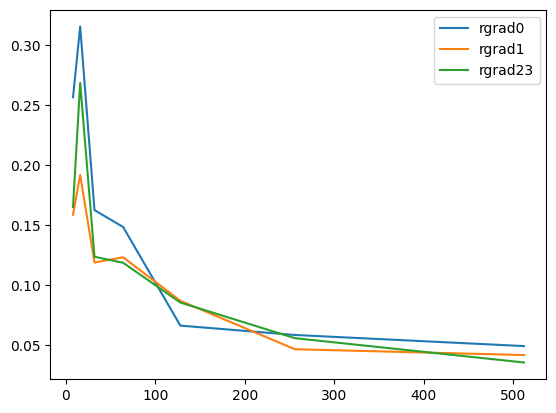

In [164]:
grads = {
    0: [],
    1: [],
    23: []
}
rgrads = {
    0: [],
    1: [],
    23: []
}
grad_stds = {
    0: [],
    1: [],
    23: []
}
rgrad_stds = {
    0: [],
    1: [],
    23: []
}

for m in [0, 1, 23]:
    for b in [8, 16, 32, 64, 128, 256, 512]:
        logger = r[(m, b)]
        grads[m].append(np.average(logger.metrics["grad_norm"][-20:]))
        rgrads[m].append(np.average(logger.metrics["real_grad_norm"][-20:]))
        grad_stds[m].append(np.std(logger.metrics["grad_norm"][-20:]))
        rgrad_stds[m].append(np.std(logger.metrics["real_grad_norm"][-20:]))

for i in [0, 1, 23]:
    # print(len(grads[i]))
    # plt.errorbar([8, 16, 32, 64, 128, 256, 512], grads[i], yerr=grad_stds[i], label=f"grad{i}")
    # plt.errorbar([8, 16, 32, 64, 128, 256, 512], rgrads[i], yerr=rgrad_stds[i], label=f"rgrad{i}")
    plt.plot([8, 16, 32, 64, 128, 256, 512], rgrads[i], label=f"rgrad{i}")
    # plt.plot([8, 16, 32, 64, 128, 256, 512], grads[i], label=f"grad{i}")

plt.legend()



0.006389965447597206
0.004805400163168088


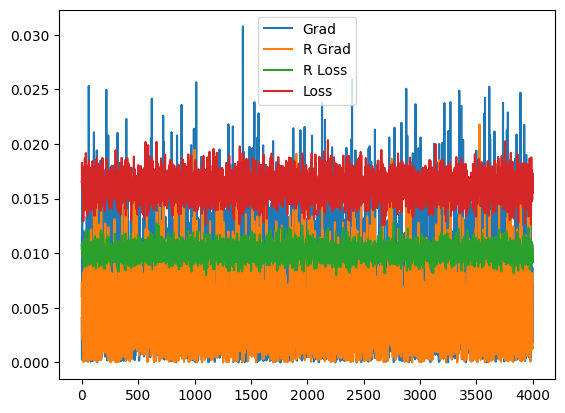

In [157]:
DATASIZE = 10000
LR = 0.01
BATCH_SIZE = 400
NOISE_SCALE = 8

w = 0.5 + torch.randn(1) * 0.001
x = torch.linspace(-1, 1, DATASIZE) 
y = 0.5 * x + 0.1 * torch.randn(DATASIZE)

# Lists to store values for plotting
weights = []
losses = []
qpoints = []
points = []
r_losses = []
r_grads = []
grads = []

number = qtorch.FloatingPoint(8, 0)
quantizer = qtorch.quant.Quantizer(number)

def getBatch(batch_size):
    indices = np.random.choice(DATASIZE, batch_size, replace=False)
    return x[indices], y[indices]

# Training loop with parameter updates
with torch.autograd.no_grad():
    for i in range(4000):
        x_batch, y_batch = getBatch(BATCH_SIZE)
        # noise = (torch.rand(*x_batch.shape) - 0.5)
        # noise[noise > 0] = 1
        # noise[noise <= 0] = -1
        # x_q = x_batch + noise
        # x_q = x_batch
        x_q = quantizer(x_batch)
        y_hat = w * x_q 
        # loss = torch.mean((y_hat - y_batch).abs())
        loss = torch.mean((y_hat - y_batch)**2)
        
        
        # Compute gradients
        # d_y_hat = torch.sign(y_hat - y_batch)
        d_y_hat = 2 * (y_hat - y_batch) / BATCH_SIZE
        # d_y_hat = quantizer(d_y_hat)

        # x_q = quantizer(x_batch)
        # noise = torch.rand(*x_batch.shape) * noise_scale
        # x_q = x_batch + noise
        # noise = (torch.rand(*x_batch.shape) - 0.5) * 2 * noise_scale
        # x_q = x_batch + noise
        x_q = quantizer(x_batch)
        d_w = (d_y_hat * x_q).sum()
        
        # Update parameters
        w -= LR * d_w
        r_loss = torch.mean((w * x_batch - y_batch)**2)
        r_grad = (2 * (w * x_batch - y_batch) * x_batch / BATCH_SIZE).sum()

        # Save parameters for animation
        # qpoints.append((x_q, y_batch))
        points.append((x, y_batch))
        weights.append(w.item())
        losses.append(loss.item())
        grads.append(d_w.abs().item())
        r_losses.append(r_loss.item())
        r_grads.append(r_grad.abs().item())


factor = 1
# plt.plot(weights, label='Weight')
plt.plot([i / factor for i in grads], label='Grad')
plt.plot(r_grads, label='R Grad')
plt.plot([i / factor for i in r_losses], label='R Loss')
plt.plot([i / factor for i in losses], label='Loss')
plt.legend()

print(np.average(grads[-100:]))
print(np.average(r_grads[-100:]))
